# Курсовая работа по численным методам по теме
# Решение краевой задачи в сложной области методом конечных элементов
## Работу выполнили студенты группы А-13б-20 Бегунов Никита и Малышкин Павел
## Вариант 2

In [1]:
import numpy as np
from pandas import DataFrame
from seaborn import heatmap
from scipy.integrate import dblquad as CalculateDoubleIntegral
from scipy.sparse.linalg import bicgstab as Solve

## Задание
Рассматривается задачи Дирихле в области  
$$
-\big{(}\frac{{\partial^2u}}{{\partial x^2}} + \frac{{\partial^2u}}{{\partial y^2}} \big{)} = f, (x, y) \in G \text{    (1)}\\
u = g, (x, y) \in \partial G \text{      (2)}
$$

Уравнение (1) описывает установившееся в какой-то бесконечно далекий момент времени, при неизменности внешней среды и внутренних физико-химических процессов, распределение температуры $u$ в пластине $G$. Здесь $f$ - плотность внутренних источников тепла, $g$ - температура внешней среды.  
Область представляет собой квадрат $0 \leq x \leq 1, 0 \leq y \leq 1$.  
Уравнение (2) описывает температуру пластины на границе.
Необходимо решить задачу методом конечных элементов.  

## Введение
Необходимо разработать алгоритм для нахождения методом конечных элементов распределения температуры u в пластине G в квадрате $0 \leq x \leq 1, 0 \leq y \leq 1$, описываемой задачей Дирихле, написать код на языке программирования $Python$, а также разработать тестовые примеры и проверить на них работоспособность полученной программы.

## Метод конечных элементов
### Вывод расчетных формул МКЭ для задачи Дирихле
Рассмотрим исходную задачу Дирихле для области:
$$-\big{(}\frac{{\partial^2u}}{{\partial x^2}} + \frac{{\partial^2u}}{{\partial y^2}} \big{)} = f$$  
Раскроем скобки и домножим обе части на некоторую функцию $\varphi$, равную нулю на границе:
$$-\frac{{\partial^2u}}{{\partial x^2}}\varphi - \frac{{\partial^2u}}{{\partial y^2}}\varphi = f\varphi, \text{где } \varphi(x,y) = 0, (x,y) \in \partial G$$  
Рассмотрим функцию
$$
\varphi(x,y) = {1\over{h}}
\begin{cases}
1 - ({x\over{h}} - i); x_i \leq x \leq x_{i+1}, y_j \leq y \leq y_j + (x - x_i); (I) \\
1 - ({y\over{h}} - j); x_i \leq x \leq x_{i+1}, y_j + (x - x_i) \leq y \leq y_{j+1}; (II) \\
1 + ({x\over{h}} - i) - ({y\over{h}} - j); x_{i-1} \leq x \leq x_i, y_j \leq y \leq y_j + (x - x_{i-1}); (III) \\
1 + ({x\over{h}} - i); x_{i-1} \leq x \leq x_i, y_{j-1} + (x - x_{i-1}) \leq y \leq y_j; (IV) \\
1 + ({y\over{h}} - j); x_{i-1} \leq x \leq x_i, y_{j-1} \leq y \leq y_{j-1} + (x - x_{i-1}); (V) \\
1 - ({x\over{h}} - i) + ({y\over{h}} - j); x_i \leq x \leq x_{i+1}, y_{j-1} + (x - x_i) \leq y \leq y_j; (VI) \\
\end{cases}
$$
И добавим интегралы по области G в обе части равенства:  
$$- \int\limits_G \frac{{\partial^2u}}{{\partial x^2}}\varphi dxdy - \int\limits_G \frac{{\partial^2u}}{{\partial y^2}}\varphi dxdy = \int\limits_G f\varphi dxdy$$  
Проинтегрируем по частям интегралы в левой части (так как функция $\varphi = 0$ на границе):
$$ \int\limits_G \frac{{\partial^2u}}{{\partial x^2}}\varphi dxdy = \int\limits_G \frac{{\partial u}}{{\partial x}}\frac{{\partial \varphi}}{{\partial x}} dxdy$$  
$$ \int\limits_G \frac{{\partial^2u}}{{\partial y^2}}\varphi dxdy = \int\limits_G \frac{{\partial u}}{{\partial y}}\frac{{\partial \varphi}}{{\partial y}} dxdy$$  
Подставим полученные интегралы:
$$ \int\limits_G \frac{{\partial u}}{{\partial x}}\frac{{\partial \varphi}}{{\partial x}} dxdy +  \int\limits_G \frac{{\partial u}}{{\partial y}}\frac{{\partial \varphi}}{{\partial y}} dxdy = \int\limits_G f\varphi dxdy $$  
Дискретизируем функцию $\varphi$ как $\varphi_{i,j}$, $1 \leq i \leq N$, $1 \leq j \leq N$, каждая из $\varphi_{i,j} = 0$ на границе. Будем искать решение задачи в виде
$$\overline u = \sum_{i=1}^N \sum_{j=1}^N \alpha_{i,j} \varphi_{i,j}(x,y)$$  
Используя $\overline u$ вычислим значения частных производных для $u$:  
$$ \frac{{\partial \overline{u}}}{{\partial x}} = \sum_{i=1}^N \sum_{j=1}^N \alpha_{i,j} \frac{{\partial \varphi_{i,j}}}{{\partial x}}$$
$$ \frac{{\partial \overline{u}}}{{\partial y}} = \sum_{i=1}^N \sum_{j=1}^N \alpha_{i,j} \frac{{\partial \varphi_{i,j}}}{{\partial y}}$$  
И подставим полученное в равенство:
$$ \int\limits_G \sum_{i=1}^N \sum_{j=1}^N \alpha_{i,j} \frac{{\partial \varphi_{i,j}}}{{\partial x}} \frac{{\partial \varphi}}{{\partial x}}dxdy + \int\limits_G \sum_{i=1}^N \sum_{j=1}^N \alpha_{i,j} \frac{{\partial \varphi_{i,j}}}{{\partial y}} \frac{{\partial \varphi}}{{\partial y}}dxdy = \int\limits_G f\varphi dxdy$$  
Поменяем местами знаки интегрирования и суммы:
$$ \sum_{i=1}^N \sum_{j=1}^N \int\limits_G \alpha_{i,j} \frac{{\partial \varphi_{i,j}}}{{\partial x}} \frac{{\partial \varphi}}{{\partial x}}dxdy + \sum_{i=1}^N \sum_{j=1}^N \int\limits_G \alpha_{i,j} \frac{{\partial \varphi_{i,j}}}{{\partial y}} \frac{{\partial \varphi}}{{\partial y}}dxdy = \int\limits_G f\varphi dxdy$$  
Теперь вместо $\varphi$ будем по очереди подставлять $\varphi_{k,l}, 1 \leq k \leq N$, $1 \leq l \leq N$ и вынесем $\alpha_{i,j}$ за знак интеграла:
$$ \sum_{i=1}^N \sum_{j=1}^N \alpha_{i,j} \int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial x}} \frac{{\partial \varphi_{k,l}}}{{\partial x}}dxdy + \sum_{i=1}^N \sum_{j=1}^N \alpha_{i,j} \int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial y}} \frac{{\partial \varphi_{k,l}}}{{\partial y}}dxdy = \int\limits_G f\varphi_{k,l} dxdy$$
Вынесем знаки суммы и $\alpha_{i,j}$ за скобки:
$$
\sum_{i=1}^N \sum_{j=1}^N \alpha_{i,j} \big{(} \int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial x}} \frac{{\partial \varphi_{k,l}}}{{\partial x}}dxdy + \int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial y}} \frac{{\partial \varphi_{k,l}}}{{\partial y}}dxdy \big{)} = \int\limits_G f\varphi_{k,l} dxdy  
$$
В случае ненулевой границы:
$$
\sum_{i=1}^N \sum_{j=1}^N \alpha_{i,j} \big{(} \int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial x}} \frac{{\partial \varphi_{k,l}}}{{\partial x}}dxdy + \int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial y}} \frac{{\partial \varphi_{k,l}}}{{\partial y}}dxdy \big{)} = \int\limits_G f\varphi_{k,l} dxdy - g_{i,j} \big{(} \int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial x}} \frac{{\partial \varphi_{k,l}}}{{\partial x}}dxdy + \int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial y}} \frac{{\partial \varphi_{k,l}}}{{\partial y}}dxdy \big{)} \text{   (3)}
$$
Где $g_{i,j}$ - известное значение функции на границе.
  
### Вычисление интегралов во всех случаях
Вычислим для функции $\varphi$ частные производные:
$$
\frac{{\partial \varphi_{i,j}}}{{\partial x}} = {1\over{h}}
\begin{cases}
-{1\over{h}}; x_i \leq x \leq x_{i+1}, y_j \leq y \leq y_j + (x - x_i); (I) \\
0; x_i \leq x \leq x_{i+1}, y_j + (x - x_i) \leq y \leq y_{j+1}; (II) \\
{1\over{h}}; x_{i-1} \leq x \leq x_i, y_j \leq y \leq y_j + (x - x_{i-1}); (III) \\
{1\over{h}}; x_{i-1} \leq x \leq x_i, y_{j-1} + (x - x_{i-1}) \leq y \leq y_j; (IV) \\
0; x_{i-1} \leq x \leq x_i, y_{j-1} \leq y \leq y_{j-1} + (x - x_{i-1}); (V) \\
-{1\over{h}}; x_i \leq x \leq x_{i+1}, y_{j+1} + (x - x_i) \leq y \leq y_j; (VI) \\
\end{cases}
$$
$$
\frac{{\partial \varphi_{i,j}}}{{\partial y}} = {1\over{h}}
\begin{cases}
0; x_i \leq x \leq x_{i+1}, y_j \leq y \leq y_j + (x - x_i); (I) \\
-{1\over{h}}; x_i \leq x \leq x_{i+1}, y_j + (x - x_i) \leq y \leq y_{j+1}; (II) \\
-{1\over{h}}; x_{i-1} \leq x \leq x_i, y_j \leq y \leq y_j + (x - x_{i-1}); (III) \\
0; x_{i-1} \leq x \leq x_i, y_{j-1} + (x - x_{i-1}) \leq y \leq y_j; (IV) \\
{1\over{h}}; x_{i-1} \leq x \leq x_i, y_{j-1} \leq y \leq y_{j-1} + (x - x_{i-1}); (V) \\
{1\over{h}}; x_i \leq x \leq x_{i+1}, y_{j+1} + (x - x_i) \leq y \leq y_j; (VI) \\
\end{cases}
$$
А теперь вычислим сумму интегралов $\int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial x}} \frac{{\partial \varphi_{k,l}}}{{\partial x}}dxdy + \int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial y}} \frac{{\partial \varphi_{k,l}}}{{\partial y}}dxdy$ при всех взаимных расположениях, то есть при i и j относительно k и l:
1. Совпадают: i = k, j = l
\begin{gather*}
\int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial x}} \frac{{\partial \varphi_{i,j}}}{{\partial x}}dxdy = \int\limits_G \big{(}\frac{{\partial \varphi_{i,j}}}{{\partial x}} \big{)}^2dxdy = \int\limits_{I} \big{(}\frac{{\partial \varphi_{i,j}}}{{\partial x}} \big{)}^2dxdy + \int\limits_{II} \big{(}\frac{{\partial \varphi_{i,j}}}{{\partial x}} \big{)}^2dxdy  + \\
+ ... + \int\limits_{VI} \big{(}\frac{{\partial \varphi_{i,j}}}{{\partial x}} \big{)}^2dxdy = 4{1\over{2h^2}} = {2\over{h^2}}  \\
\int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial y}} \frac{{\partial \varphi_{i,j}}}{{\partial y}}dxdy = \int\limits_G \big{(}\frac{{\partial \varphi_{i,j}}}{{\partial y}} \big{)}^2dxdy = \int\limits_{I} \big{(}\frac{{\partial \varphi_{i,j}}}{{\partial y}} \big{)}^2dxdy + \int\limits_{II} \big{(}\frac{{\partial \varphi_{i,j}}}{{\partial y}} \big{)}^2dxdy +\\
+ ... + \int\limits_{VI} \big{(}\frac{{\partial \varphi_{i,j}}}{{\partial y}} \big{)}^2dxdy = 4{1\over{2h^2}} = {2\over{h^2}} \\
\int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial x}} \frac{{\partial \varphi_{i,j}}}{{\partial x}}dxdy + \int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial y}} \frac{{\partial \varphi_{i,j}}}{{\partial y}}dxdy = {4\over{h^2}}
\end{gather*}

2. Смещение вправо на 1: i = k + 1, j = l
\begin{gather*}
\int\limits_G \frac{{\partial \varphi_{i+1,j}}}{{\partial x}} \frac{{\partial \varphi_{i,j}}}{{\partial x}}dxdy =  -{1\over{h^2}} \\
\int\limits_G \frac{{\partial \varphi_{i+1,j}}}{{\partial y}} \frac{{\partial \varphi_{i,j}}}{{\partial y}}dxdy = 0 \\
\int\limits_G \frac{{\partial \varphi_{i+1,j}}}{{\partial x}} \frac{{\partial \varphi_{i,j}}}{{\partial x}}dxdy + \int\limits_G \frac{{\partial \varphi_{i+1,j}}}{{\partial y}} \frac{{\partial \varphi_{i,j}}}{{\partial y}}dxdy = -{1\over{h^2}}
\end{gather*}

3. Смещение вправо-вверх на 1: i = k + 1; j = l + 1
\begin{gather*}
\int\limits_G \frac{{\partial \varphi_{i+1,j+1}}}{{\partial x}} \frac{{\partial \varphi_{i,j}}}{{\partial x}}dxdy = 0 \\
\int\limits_G \frac{{\partial \varphi_{i+1,j+1}}}{{\partial y}} \frac{{\partial \varphi_{i,j}}}{{\partial y}}dxdy = 0 \\
\int\limits_G \frac{{\partial \varphi_{i+1,j+1}}}{{\partial x}} \frac{{\partial \varphi_{i,j}}}{{\partial x}}dxdy + \int\limits_G \frac{{\partial \varphi_{i+1,j+1}}}{{\partial y}} \frac{{\partial \varphi_{i,j}}}{{\partial y}}dxdy = 0
\end{gather*}
4. Смещение вверх на 1: i = k; j = l + 1
\begin{gather*}
\int\limits_G \frac{{\partial \varphi_{i+1,j+1}}}{{\partial x}} \frac{{\partial \varphi_{i,j}}}{{\partial x}}dxdy = 0 \\
\int\limits_G \frac{{\partial \varphi_{i+1,j+1}}}{{\partial y}} \frac{{\partial \varphi_{i,j}}}{{\partial y}}dxdy = -{1\over{h^2}} \\
\int\limits_G \frac{{\partial \varphi_{i+1,j+1}}}{{\partial x}} \frac{{\partial \varphi_{i,j}}}{{\partial x}}dxdy + \int\limits_G \frac{{\partial \varphi_{i+1,j+1}}}{{\partial y}} \frac{{\partial \varphi_{i,j}}}{{\partial y}}dxdy = -{1\over{h^2}}
\end{gather*}
5. Смещение влево на 1: i = k - 1; j = l
\begin{gather*}
\int\limits_G \frac{{\partial \varphi_{i-1,j}}}{{\partial x}} \frac{{\partial \varphi_{i,j}}}{{\partial x}}dxdy = -{1\over{h^2}} \\
\int\limits_G \frac{{\partial \varphi_{i-1,j}}}{{\partial y}} \frac{{\partial \varphi_{i,j}}}{{\partial y}}dxdy = 0 \\
\int\limits_G \frac{{\partial \varphi_{i-1,j}}}{{\partial x}} \frac{{\partial \varphi_{i,j}}}{{\partial x}}dxdy + \int\limits_G \frac{{\partial \varphi_{i-1,j}}}{{\partial y}} \frac{{\partial \varphi_{i,j}}}{{\partial y}}dxdy = -{1\over{h^2}}
\end{gather*}
6. Смещение влево-вниз на 1: i = k - 1; j = l - 1
\begin{gather*}
\int\limits_G \frac{{\partial \varphi_{i-1,j-1}}}{{\partial x}} \frac{{\partial \varphi_{i,j}}}{{\partial x}}dxdy = 0 \\
\int\limits_G \frac{{\partial \varphi_{i-1,j-1}}}{{\partial y}} \frac{{\partial \varphi_{i,j}}}{{\partial y}}dxdy = 0 \\
\int\limits_G \frac{{\partial \varphi_{i-1,j-1}}}{{\partial x}} \frac{{\partial \varphi_{i,j}}}{{\partial x}}dxdy + \int\limits_G \frac{{\partial \varphi_{i-1,j-1}}}{{\partial y}} \frac{{\partial \varphi_{i,j}}}{{\partial y}}dxdy = 0
\end{gather*}
7. Смещение вниз на 1: i = k; j = l - 1
\begin{gather*}
\int\limits_G \frac{{\partial \varphi_{i,j-1}}}{{\partial x}} \frac{{\partial \varphi_{i,j}}}{{\partial x}}dxdy = 0 \\
\int\limits_G \frac{{\partial \varphi_{i,j-1}}}{{\partial y}} \frac{{\partial \varphi_{i,j}}}{{\partial y}}dxdy = -{1\over{h^2}} \\
\int\limits_G \frac{{\partial \varphi_{i,j-1}}}{{\partial x}} \frac{{\partial \varphi_{i,j}}}{{\partial x}}dxdy + \int\limits_G \frac{{\partial \varphi_{i,j-1}}}{{\partial y}} \frac{{\partial \varphi_{i,j}}}{{\partial y}}dxdy = -{1\over{h^2}}
\end{gather*}
8. Во всех остальных случаях
\begin{gather*}
\int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial x}} \frac{{\partial \varphi_{k,l}}}{{\partial x}}dxdy = 0 \\
\int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial y}} \frac{{\partial \varphi_{k,l}}}{{\partial y}}dxdy = 0 \\
\int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial x}} \frac{{\partial \varphi_{k,l}}}{{\partial x}}dxdy + \int\limits_G \frac{{\partial \varphi_{i,j}}}{{\partial y}} \frac{{\partial \varphi_{k,l}}}{{\partial y}}dxdy = 0
\end{gather*}
Таким образом, решение уравнения (3) сводится к решению СЛАУ $Ax=b$, где матрица $A$ - пятидиагональная, на главное диагонали находится значение ${4\over h^2}$, справа и слева от нее находятся значения $-{1\over h^2}$, а также слева и справа на удалении N находятся значения $-{1\over h^2}$, за исключением тех мест, где k или l доходят до границы. Пример матрицы A при шаге h = 0.25:
$$
A = 
\begin{pmatrix}
    64& -16& 0& -16& 0& 0& 0& 0& 0& \\
    -16& 64& -16& 0& -16& 0& 0& 0& 0& \\
    0& -16& 64& 0& 0& -16& 0& 0& 0& \\
    -16& 0& 0& 64& -16& 0& -16& 0& 0& \\
    0& -16& 0& -16& 64& -16& 0& -16& 0& \\
    0& 0& -16& 0& -16& 64& 0& 0& -16& \\
    0& 0& 0& -16& 0& 0& 64& -16& 0& \\
    0& 0& 0& 0& -16& 0& -16& 64& -16& \\
    0& 0& 0& 0& 0& -16& 0& -16& 64&
\end{pmatrix}
$$
Вектор $b$ вычисляется с помощью двойных интегралов, значения которых зависят от $i$ и $j$:
$$
b = 
\begin{pmatrix}
    \int\limits_G f\varphi_{1,1} dxdy + u_{0, 1} * {1\over h^2} + u_{1, 0} * {1\over h^2} \\
    \vdots \\ 
    \int\limits_G f\varphi_{N,N} dxdy + u_{N, N+1} * {1\over h^2} + u_{N+1, N} * 
    {1\over h^2}
\end{pmatrix}
$$

## Построение тестовых примеров
Напишем функцию для вывода ожидаемого результата.

In [2]:
# Функция для вывода результата оригинальной функции
def DrawOriginal(u, h):
    n = int(1/h)+1
    A = np.zeros((n, n), dtype = float)
    for i in range(n):
        for j in range(n):
            A[n-j-1][i] = u(i*h, j*h)

    resultheat = DataFrame(A)
    heatmap(resultheat, square = True,
            xticklabels = False, yticklabels = False)

### Реальные тестовые примеры
#### Первый тестовый пример
Рассмотрим функию $u = sin(\pi x)cos(2πy + {\pi\over2})$, равную нулю на границе. Найдем для нее частные производные и вычислим функцию $f$:
\begin{gather*}
\frac {\partial^2u}{\partial x^2} = -\pi^2sin(\pi x)cos(2\pi y + {\pi\over 2}) \\
\frac {\partial^2u}{\partial y^2} = -4\pi^2 cos(2\pi y + {\pi\over 2})sin(\pi x) \\
f = 5\pi^2cos(2\pi y + {\pi\over2})sin(\pi x)
\end{gather*}
На границе функция равна нулю:
\begin{gather*}
u(0, y) = 0,\ 0 \leq y \leq 1 \\
u(1, y) = 0,\ 0 \leq y \leq 1 \\
u(x, 0) = 0,\ 0 \leq x \leq 1 \\
u(x, 1) = 0,\ 0 \leq x \leq 1
\end{gather*}

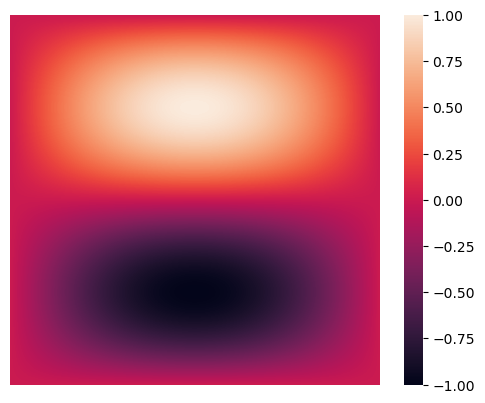

In [3]:
def u1(x, y):
    return np.sin(np.pi * x) * np.cos(2*np.pi*y+np.pi/2)

h = 0.001
DrawOriginal(u1, h)

#### Второй тестовый пример
Далее рассмотрим простую функцию $u = x$, которая на границе уже не равна нулю. Для нее проделаем те же операции, что и с первой функцией:
\begin{gather*}
\frac {\partial^2u}{\partial x^2} = 0 \\
\frac {\partial^2u}{\partial y^2} = 0 \\
f = 0
\end{gather*}
Получается, что в данном тестовом примере проверяется функция с правой частью равной нулю. Найдем для нее так же значения на границе:
\begin{gather*}
u(0, y) = 0,\ 0 \leq y \leq 1 \\
u(1, y) = 1,\ 0 \leq y \leq 1 \\
u(x, 0) = x,\ 0 \leq x \leq 1 \\
u(x, 1) = x,\ 0 \leq x \leq 1
\end{gather*}

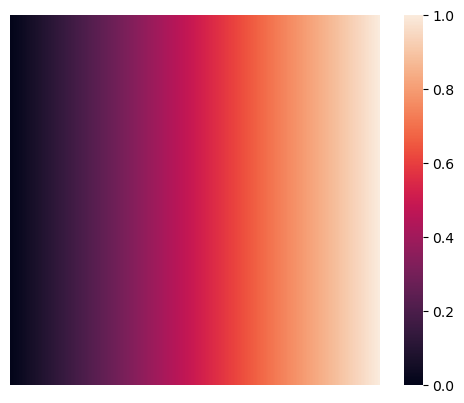

In [4]:
def u2(x, y):
    return x

h = 0.001
DrawOriginal(u2, h)

#### Третий тестовый пример
Рассмотрим третий уже более сложный пример с $u = (x-0.5)^2 + (y-0.5)^3$ с правой частью не равной нулю и ненулевой границей. Аналогично вычислим значения частных производных и найдем функцию $f$:
\begin{gather*}
\frac {\partial^2u}{\partial x^2} = 2 \\
\frac {\partial^2u}{\partial y^2} = 6y-3 \\
f = 1 - 6y
\end{gather*}
Найдем ее значения на границе:
\begin{gather*}
u(0, y) = (y-0.5)^3 + 0.25,\ 0 \leq y \leq 1 \\
u(1, y) = (y-0.5)^3 + 0.25,\ 0 \leq y \leq 1 \\
u(x, 0) = (x-0.5)^2 - 0.125,\ 0 \leq x \leq 1 \\
u(x, 1) = (x-0.5)^2 + 0.125,\ 0 \leq x \leq 1
\end{gather*}

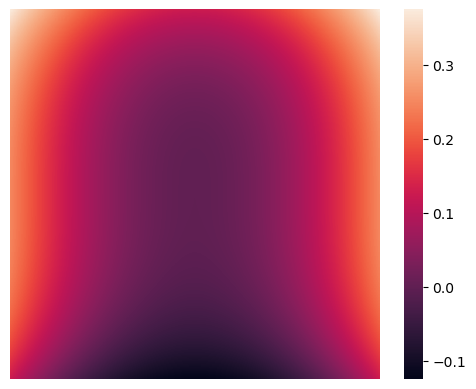

In [5]:
def u3(x, y):
    return (x-0.5)**2 + (y-0.5)**3

h = 0.001
DrawOriginal(u3, h)

### Искусственные тестовые примеры
#### Четвертый тестовый пример
Создадим тестовый пример для проверки работоспрособности программы при малой области функции $f$. Для этого зададим функцию $f$:
\begin{gather*}
f(x) = 
    \begin{cases}
    1, &\text{(x, y) $\in (x-0.3)^2 + (y-0.5)^2 = (0.01)^2$}\\
    0, &\text{иначе}
    \end{cases}
\end{gather*}
Данный тестовый пример равен нулю на границе:
\begin{gather*}
u(0, y) = 0,\ 0 \leq y \leq 1 \\
u(1, y) = 0,\ 0 \leq y \leq 1 \\
u(x, 0) = 0,\ 0 \leq x \leq 1 \\
u(x, 1) = 0,\ 0 \leq x \leq 1
\end{gather*}

#### Пятый тестовый пример
Создадим тестовый пример для проверки работоспрособности программы при малой области на границе. Функция $f$ в данном тестовом примере будет равна нулю:
\begin{gather*}
f = 0
\end{gather*}
Зададим малый участок $x \in [0.1,\ 0.101]$ на нижней и верхней границах:
\begin{gather*}
u(0, y) = 
\begin{cases}
    1 , &\text{x $\in [0.1,0.101]$}\\
    0 , &\text{иначе}
\end{cases},\ 0 \leq y \leq 1 \\
u(1, y) = 
\begin{cases}
    1 , &\text{x $\in [0.1,0.101]$}\\
    0 , &\text{иначе}
\end{cases},\ 0 \leq y \leq 1 \\
u(x, 0) = 0,\ 0 \leq x \leq 1 \\
u(x, 1) = 0,\ 0 \leq x \leq 1
\end{gather*}

## Описание алгоритма программы
Для решения поставленной задачи создадим фунцию Calculate, принимающую в качестве аргументов шаг вычисления $h$, функцию $f$ и границу $Border$. Функция будет проходить последовательно снизу вверх и слева направо по области с шагом $h$ и заполнять матрицу левой части в зависимости от расположения «домиков». Вектор правой части вычисляется с помощью функции вычисления двойных интегралов из пакета $scipy$. Полученная СЛАУ $Ax = b$ решается с помощью функции решения СЛАУ так же из пакета $scipy$ с точностью $10^{-10}$. Математические операции производятся с помощью пакета $numpy$. Для построения тепловой карты преобразуется размер полученного решения в двумерный массив, инвертируется ось y и преобразуется в $DataFrame$ из пакета $pandas$. Для построения полученной тепловой карты используется функция $heatmap$ из пакета $seaborn$.

In [6]:
# Функция вычисления методом конечных элементов
def Calculate(h, F, Border):
    def RightPart(i, j, h, f, Border):
        def phi1(phiy, phix):
            return 1/h *(1 - phix/h + i) * f(phix, phiy)
        def phi2(phiy, phix):
            return 1/h * (1 - phiy/h + j) * f(phix, phiy)
        def phi3(phiy, phix):
            return 1/h * (1 + phix/h - i - phiy/h + j) * f(phix, phiy)
        def phi4(phiy, phix):
            return 1/h * (1 + phix/h - i) * f(phix, phiy)
        def phi5(phiy, phix):
            return 1/h * (1 + phiy/h - j) * f(phix, phiy)
        def phi6(phiy, phix):
            return 1/h * (1 - phix/h + i + phiy/h - j) * f(phix, phiy)
        
        xi = i*h
        yj = j*h
        res = 0
        res += CalculateDoubleIntegral(phi1, xi, xi+h, yj, lambda t: yj+t-xi)[0]
        res += CalculateDoubleIntegral(phi2, xi, xi+h, lambda t: yj+t-xi, yj+h)[0]
        res += CalculateDoubleIntegral(phi3, xi-h, xi, yj, lambda t: yj+t-(xi-h))[0]
        res += CalculateDoubleIntegral(phi4, xi-h, xi, lambda t: yj-h+t-(xi-h), yj)[0]
        res += CalculateDoubleIntegral(phi5, xi-h, xi, yj-h, lambda t: yj-h+t-(xi-h))[0]
        res += CalculateDoubleIntegral(phi6, xi, xi+h, lambda t: yj-h+t-xi, yj)[0]
        res /= h
        
        if xi - h == 0 and yj - h == 0:
            res += Border(xi-h, yj) * 1/(h**2) + Border(xi, yj-h) * 1/(h**2)
        elif xi + h == 1 and yj - h == 0:
            res += Border(xi+h, yj) * 1/(h**2)  + Border(xi, yj-h) * 1/(h**2)
        elif xi - h == 0 and yj + h == 1:
            res += Border(xi-h, yj) * 1/(h**2) + Border(xi, yj+h) * 1/(h**2)
        elif xi + h == 1 and yj + h == 1:
            res += Border(xi+h, yj) * 1/(h**2) + Border(xi, yj+h) * 1/(h**2)
        elif xi - h == 0:
            res += Border(xi-h, yj) * 1/(h**2)
        elif xi + h == 1:
            res += Border(xi+h, yj) * 1/(h**2)
        elif yj - h == 0:
            res += Border(xi, yj-h) * 1/(h**2)
        elif yj + h == 1:
            res += Border(xi, yj+h) * 1/(h**2)
        
        return res
    
    n = int(1/h) - 1
    h = 1/(n+1)
    A = np.zeros((n**2, n**2))
    rp = []
    for j in range(n): #y
        for i in range(n): #x
            m = j*n + i
            A[m][m] = 4/(h**2)
            if (i > 0): #L
                A[m][m - 1] = -1/(h**2)
            if (i < n - 1): #R
                A[m][m + 1] = -1/(h**2)
            if (j > 0): #D
                A[m][m - n] = -1/(h**2)
            if (j < n - 1): #U
                A[m][m + n] = -1/(h**2)
            rp.append(RightPart(i+1, j+1, h, F, Border))
    
    return Solve(A, rp, tol=10**(-10))[0], n

## Решение программой тестовых примеров
Напишем функцию для вывода результата, полученного методом конечных элементов.

In [7]:
# Функция для вывода результата, вычисленного программой
def DrawPicture(result, n):
    result = result.reshape(n, n)
    # Инвертируем ось y для правильного построения тепловой карты
    resultInv = np.zeros((n, n))
    for i in range(len(result)):
        resultInv[n - 1 - i] = result[i].copy()
    resultheat = DataFrame(resultInv)
    heatmap(resultheat, square = True,
            xticklabels = False, yticklabels = False)

Для начала оценим работу программы на реальных примерах.
Запустим программу на первом тестовом примере (с шагом $h=0.01$):

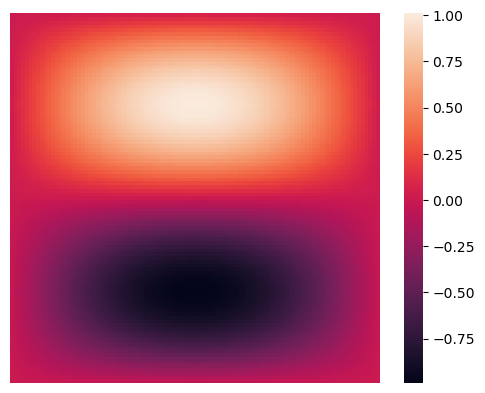

In [8]:
def f1(x, y):
    return 5 * np.pi**2 * np.cos(2 * np.pi*y+ np.pi/2) * np.sin(np.pi*x)

def Border1(x, y):
    return 0.01

h = 0.01
result, n = Calculate(h, f1, Border1)
DrawPicture(result, n)

Запустим программу на втором тестовом примере (с шагом $h=0.01$):

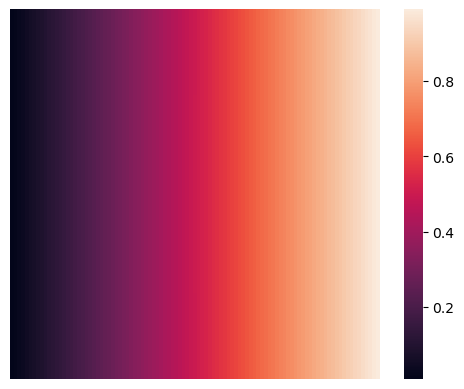

In [9]:
def f2(x, y):
    return 0

def Border2(x, y):
    if x == 0:
        return 0
    elif x == 1:
        return 1
    elif y == 0:
        return x
    elif y == 1:
        return x

h = 0.01
result, n = Calculate(h, f2, Border2)
DrawPicture(result, n)

Запустим программу на третьем тестовом примере (с шагом $h=0.01$):

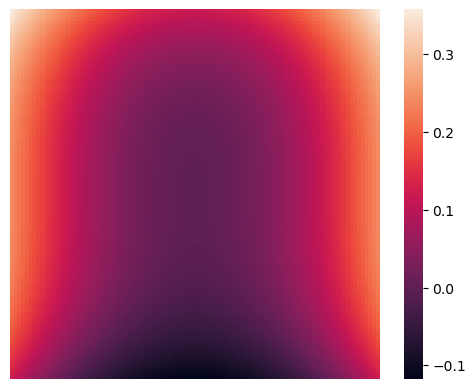

In [10]:
def f3(x, y):
    return 1 - 6*y

def Border3(x, y):
    if x == 0:
        return (y - 0.5)**3 + 0.25
    elif x == 1:
        return (y - 0.5)**3 + 0.25
    elif y == 0:
        return (x - 0.5)**2 - 0.125
    elif y == 1:
        return (x - 0.5)**2 + 0.125

h = 0.01
result, n = Calculate(h, f3, Border3)
DrawPicture(result, n)

Как видно, результаты, вычисленные с помощью программы, полностью совпадают с ожидаемыми, описанными в тестовых примерах.
Теперь запустим программу на искуственных тестовых примерах. Четвертый тестовый пример (с шагом $h=0.01$):

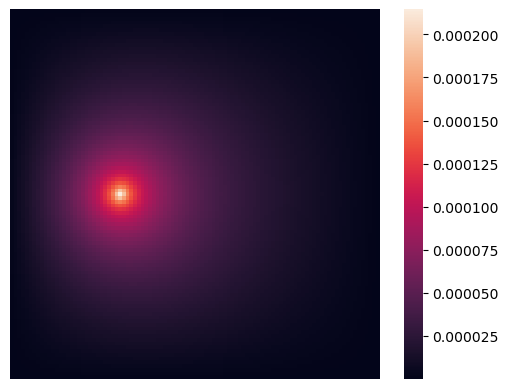

In [11]:
def f4(x, y):
    if (x-0.3)**2 + (y-0.5)**2 <= 0.01**2:
        return 1
    else:
        return 0

def Border4(x, y):
    return 0

h = 0.01
result, n = Calculate(h, f4, Border4)
DrawPicture(result, n)

Запустим программу на пятом тестовом примере (с шагом $h=0.01$):

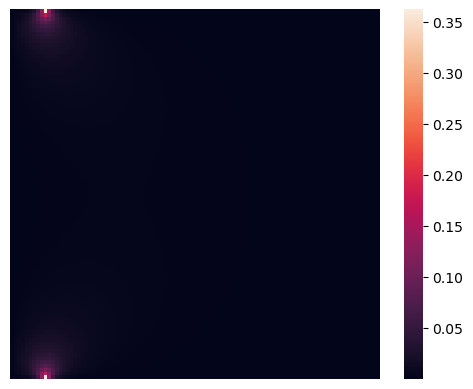

In [12]:
def f5(x, y):
    return 0

def Border5(x, y):
    if x >= 0.1 and x <= 0.101:
        return 1
    else:
        return 0

h = 0.01
result, n = Calculate(h, f5, Border5)
DrawPicture(result, n)

Как видно, искуственные тестовые примеры работают так же корректно и отображают участки на необходимых местах.

## Заключение
В результате выполенения курсовой работы удалось построить метод для нахождения распределения температуры u в пластине G в квадрате $0 \leq x \leq 1, 0 \leq y \leq 1$, то есть решения краевой задачи, заданной задачей Дирихле, заданной уравнением Пуассона. Так же были составлены тестовые примеры для проверки работоспрособности программы и написан код для решения поставленной задачи на языке программирования $Python$. После проверки работоспособности программы получилось, что ожидаемые результаты совпали с полученными, то есть написанная программа работает полностью корректно.

## Список использованных источников
1. Г.И. Марчук, В.И. Агошков. Введение в проекционно сеточные методы - Москва «НАУКА» 1981
2. А.А. Амосов, Ю.А. Дубинский, Н.В. Копченова. Вычислительные методы для инженеров - Москва «Высшая школа» 1994